<div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Verdana;text-align:center;
border-radius:15px;
background: linear-gradient(135deg, #0F2027, #203A43, #2C5364); 
text-shadow: 2px 2px 10px #89CFF0;
box-shadow: 0px 0px 25px #89CFF0;
height: auto; overflow:hidden;
backdrop-filter: blur(10px); 
transition: transform 0.3s ease-in-out;"
onmouseover="this.style.transform='scale(1.08)'"
onmouseout="this.style.transform='scale(1)'">
<b> ✨ Import Required Library ✨ </b>
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
%matplotlib inline
from prophet import Prophet
import tensorflow as tf
from keras.models import load_model
import mlflow
import sys
from tensorflow.keras.models import Sequential
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score

In [2]:
# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

<div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Verdana;text-align:center;
border-radius:15px;
background: linear-gradient(135deg, #0F2027, #203A43, #2C5364); 
text-shadow: 2px 2px 10px #89CFF0;
box-shadow: 0px 0px 25px #89CFF0;
padding: 10px; height: auto; overflow:hidden; 
backdrop-filter: blur(8px); 
transition: transform 0.3s ease-in-out;"
onmouseover="this.style.transform='scale(1.05)'"
onmouseout="this.style.transform='scale(1)'">
<b> ✨ Loading Dataset ✨ </b>
</div>

In [3]:
# Load The datasets
df_train = pd.read_csv("E:\Project_6_Sales Forecasting Across Multiple Retail Store\df_train_for_deeplearning.csv", index_col='Date', parse_dates=True)
df_test = pd.read_csv("E:\Project_6_Sales Forecasting Across Multiple Retail Store\df_test_for_deeplearning.csv", index_col='Date', parse_dates=True,)

In [4]:
# Check dataset
df_train.head(5)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,Weekday,IsWeekend,IsBeginningOfMonth,IsMidMonth,IsEndOfMonth,Quarter,IsHolidaySeason,PromoIntervalMonths,PromoRunningDays,CompetitionDurationMonths
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,4,5263,555,1,1,0.0,1,2.0,0.0,...,4,0.0,0.0,0.0,1.0,3,0.0,"[1, 4, 7, 10]",211,82
2015-07-31,2,4,6064,625,1,1,0.0,1,0.0,0.0,...,4,0.0,0.0,0.0,1.0,3,0.0,"[1, 4, 7, 10]",211,92
2015-07-31,3,4,8314,821,1,1,0.0,1,0.0,0.0,...,4,0.0,0.0,0.0,1.0,3,0.0,"[1, 4, 7, 10]",211,103
2015-07-31,4,4,13995,1485,1,1,0.0,1,2.0,2.0,...,4,0.0,0.0,0.0,1.0,3,0.0,"[1, 4, 7, 10]",211,70
2015-07-31,5,4,4822,559,1,1,0.0,1,0.0,0.0,...,4,0.0,0.0,0.0,1.0,3,0.0,"[1, 4, 7, 10]",211,3


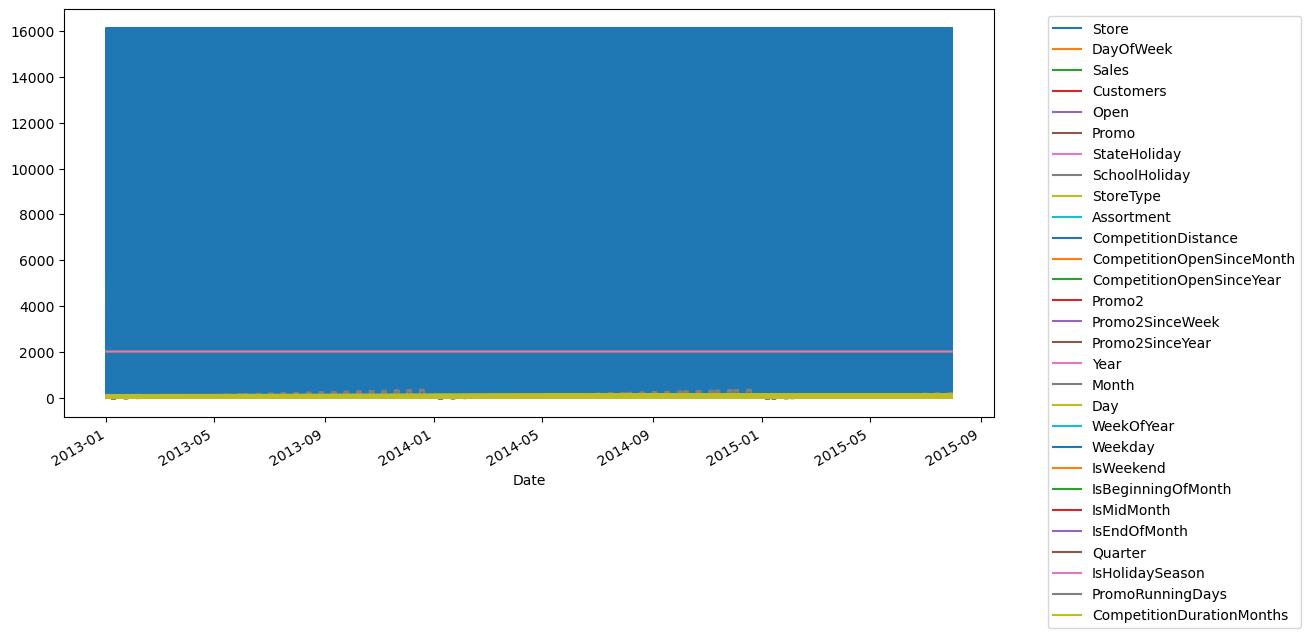

In [5]:
# showing Data in Timeseries
df_train.plot(figsize = (12,6))
plt.legend(loc='upper left',bbox_to_anchor=(1.05,1))
plt.show()

In [6]:
# Isolate the sales data into time series data
sales_data = df_train[['Sales']].copy()
sales_data = sales_data.resample('D').sum()

In [7]:
# Function to check stationarity
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    logger.info('ADF Statistic: %f', result[0])
    logger.info('p-value: %f', result[1])
    for key, value in result[4].items():
        logger.info('Critical Values:')
        logger.info('%s: %.3f', key, value)
    if result[1] > 0.05:
        logger.info("Time series is not stationary")
        return False
    else:
        logger.info("Time series is stationary")
        return True

In [8]:
# Check whether the time series data is stationary
if not check_stationarity(sales_data['Sales']):
    sales_data['Sales_diff'] = sales_data['Sales'] - sales_data['Sales'].shift(1)
    sales_data.dropna(inplace=True)

    if not check_stationarity(sales_data['Sales_diff']):
        logger.error("Differenced time series is still not stationary.")
else:
    sales_data['Sales_diff'] = sales_data['Sales']

INFO:__main__:ADF Statistic: -4.680460
INFO:__main__:p-value: 0.000092
INFO:__main__:Critical Values:
INFO:__main__:1%: -3.437
INFO:__main__:Critical Values:
INFO:__main__:5%: -2.865
INFO:__main__:Critical Values:
INFO:__main__:10%: -2.568
INFO:__main__:Time series is stationary


<div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Verdana;text-align:center;
border-radius:15px;
background: linear-gradient(135deg, #0F2027, #203A43, #2C5364); 
text-shadow: 2px 2px 10px #89CFF0;
box-shadow: 0px 0px 25px #89CFF0;
padding: 10px; height: auto; overflow:hidden; 
backdrop-filter: blur(8px); 
transition: transform 0.3s ease-in-out;"
onmouseover="this.style.transform='scale(1.05)'"
onmouseout="this.style.transform='scale(1)'">
<b> ✨ stationarity of data in chunks ✨ </b>
</div>

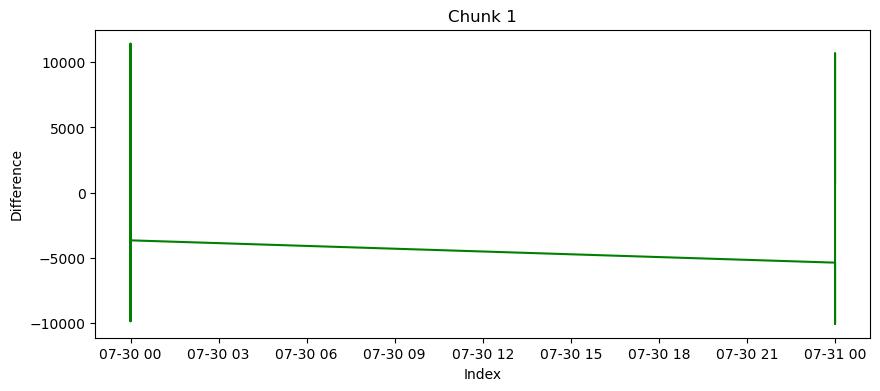

Chunk 1
ADF Stastistics:  -15.269509415705803
p-values:  4.738346057123857e-28
Critical Values:  {'1%': -3.433683944723065, '5%': -2.863012742456624, '10%': -2.567554027619348}
Reject the null hypothesis - Data is stationary
Chunk 2 contains only constant values.
Chunk 3 contains only constant values.
Chunk 4 contains only constant values.
Chunk 5 contains only constant values.
Chunk 6 contains only constant values.
Chunk 7 contains only constant values.
Chunk 8 contains only constant values.
Chunk 9 contains only constant values.
Chunk 10 contains only constant values.
Chunk 11 contains only constant values.
Chunk 12 contains only constant values.
Chunk 13 contains only constant values.
Chunk 14 contains only constant values.
Chunk 15 contains only constant values.
Chunk 16 contains only constant values.
Chunk 17 contains only constant values.
Chunk 18 contains only constant values.
Chunk 19 contains only constant values.
Chunk 20 contains only constant values.
Chunk 21 contains only 

In [9]:
# Check the stationarity of data in chunks
def test_stationary(timeseries, chunk_size = 2000):
    n = len(timeseries)
    for i in range(0,n,chunk_size):
        chunk = timeseries.iloc[i:min(1 + chunk_size, n)]
        chunk_diff = chunk.diff().fillna(0)
        chunk_diff_nonzero = chunk_diff[chunk_diff != 0]
        
        if len(chunk_diff_nonzero) == 0:
            print(f"Chunk {i // chunk_size + 1} contains only constant values.")
            continue
            
        result = adfuller(chunk_diff_nonzero, autolag= 'AIC')
        
        plt.figure(figsize=(10,4))
        plt.plot(chunk_diff_nonzero, color = 'green')
        plt.title(f"Chunk {i // chunk_size + 1}")
        plt.xlabel('Index')
        plt.ylabel('Difference')
        plt.show()
        
        print('Chunk', i // chunk_size + 1)
        print('ADF Stastistics: ',result[0])
        print('p-values: ',result[1])
        print('Critical Values: ',result[4])
        
        if result[1] <= 0.05:
            print('Reject the null hypothesis - Data is stationary')
        else:
            print('Fail to reject the null hypothesis - Data is non stationary')
            
test_stationary(df_train['Sales'])

In [10]:
# Differencing to make the time series stationary
data_diffr = df_train['Sales'].diff().dropna()

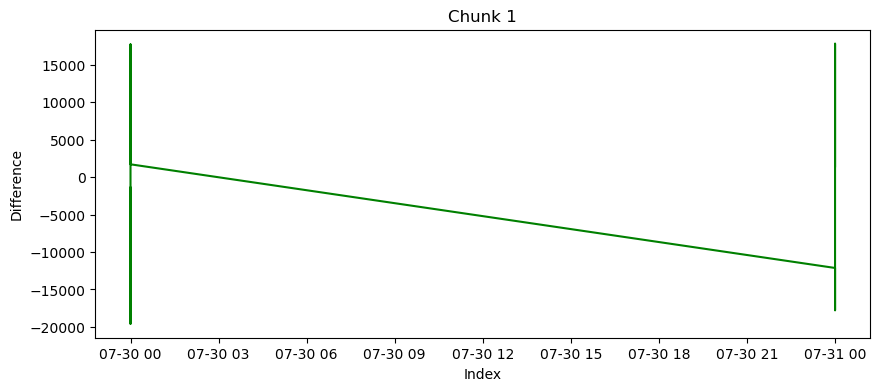

Chunk 1
ADF Stastistics:  -19.637261036378348
p-values:  0.0
Critical Values:  {'1%': -3.4336720887549483, '5%': -2.863007508094813, '10%': -2.567551240570721}
Reject the null hypothesis - Data is stationary
Chunk 2 contains only constant values.
Chunk 3 contains only constant values.
Chunk 4 contains only constant values.
Chunk 5 contains only constant values.
Chunk 6 contains only constant values.
Chunk 7 contains only constant values.
Chunk 8 contains only constant values.
Chunk 9 contains only constant values.
Chunk 10 contains only constant values.
Chunk 11 contains only constant values.
Chunk 12 contains only constant values.
Chunk 13 contains only constant values.
Chunk 14 contains only constant values.
Chunk 15 contains only constant values.
Chunk 16 contains only constant values.
Chunk 17 contains only constant values.
Chunk 18 contains only constant values.
Chunk 19 contains only constant values.
Chunk 20 contains only constant values.
Chunk 21 contains only constant values.


In [11]:
test_stationary(data_diffr)

<div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Verdana;text-align:center;
border-radius:15px;
background: linear-gradient(135deg, #0F2027, #203A43, #2C5364); 
text-shadow: 2px 2px 10px #89CFF0;
box-shadow: 0px 0px 25px #89CFF0;
padding: 10px; height: auto; overflow:hidden; 
backdrop-filter: blur(8px); 
transition: transform 0.3s ease-in-out;"
onmouseover="this.style.transform='scale(1.05)'"
onmouseout="this.style.transform='scale(1)'">
<b> ✨ ACF Plot for sales ✨ </b>
</div>

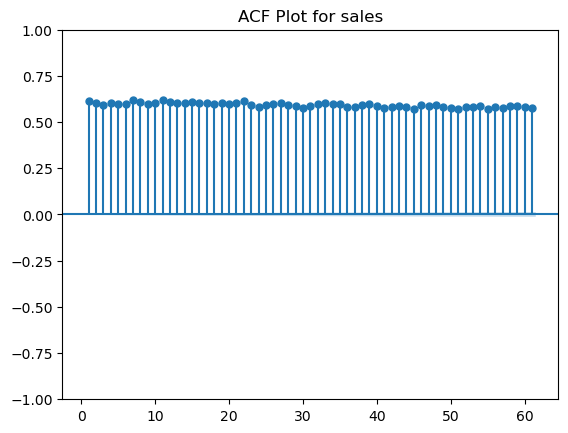

In [12]:
acf_plot = plot_acf(df_train['Sales'],title = 'ACF Plot for sales', zero=False)
plt.show()

<div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Verdana;text-align:center;
border-radius:15px;
background: linear-gradient(135deg, #0F2027, #203A43, #2C5364); 
text-shadow: 2px 2px 10px #89CFF0;
box-shadow: 0px 0px 25px #89CFF0;
padding: 10px; height: auto; overflow:hidden; 
backdrop-filter: blur(8px); 
transition: transform 0.3s ease-in-out;"
onmouseover="this.style.transform='scale(1.05)'"
onmouseout="this.style.transform='scale(1)'">
<b> ✨ PACF Plot for sales ✨ </b>
</div>

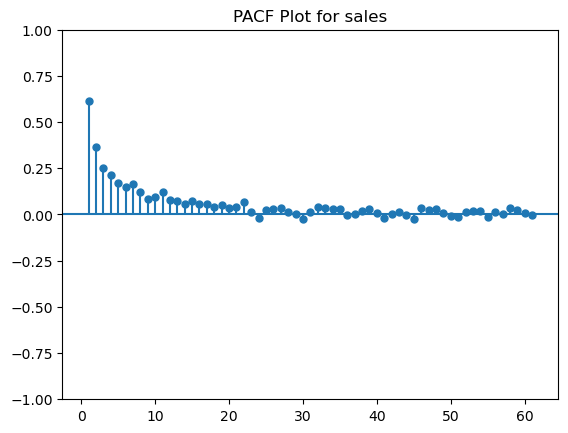

In [13]:
pacf_plot = plot_pacf(df_train['Sales'],title = 'PACF Plot for sales', zero=False)
plt.show()

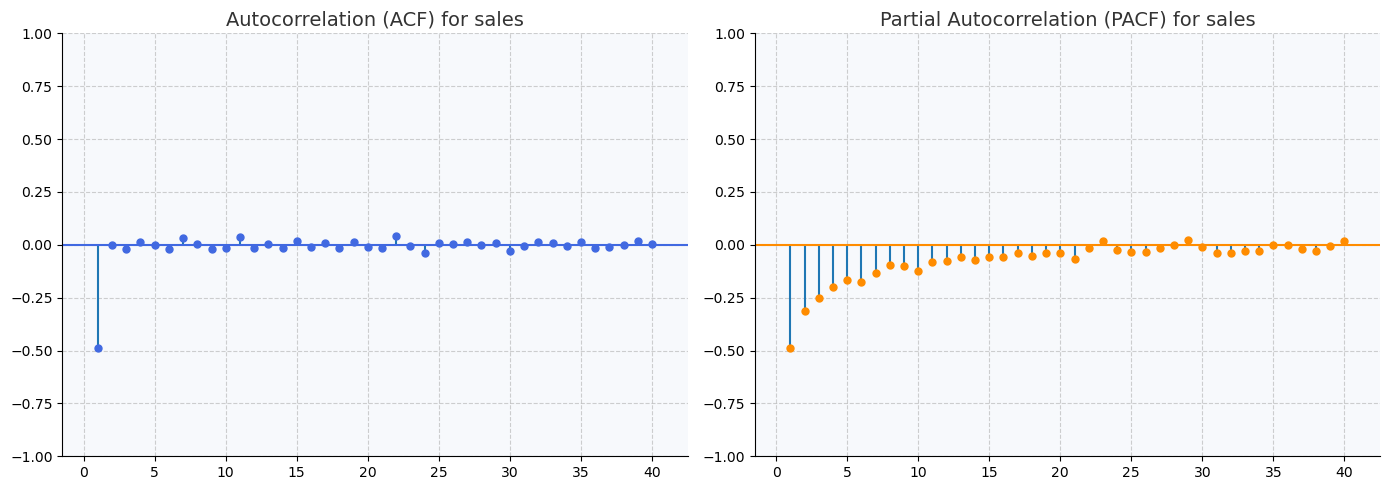

In [14]:
# Plot Autocorrelation and Partial Autocorrelation
diff_series = df_train['Sales'].diff().dropna()
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=100)
plot_acf(diff_series, lags=40, ax=axes[0], title='Autocorrelation (ACF) for sales', zero=False, 
         color='royalblue', alpha=0.7)

plot_pacf(diff_series, lags=40, ax=axes[1], title='Partial Autocorrelation (PACF) for sales', zero=False, 
          color='darkorange', alpha=0.7, method='ywm')

for ax in axes:
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_facecolor('#f7f9fc')
    ax.title.set_size(14)
    ax.title.set_color('#333333')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

<div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Verdana;text-align:center;
border-radius:15px;
background: linear-gradient(135deg, #0F2027, #203A43, #2C5364); 
text-shadow: 2px 2px 10px #89CFF0;
box-shadow: 0px 0px 25px #89CFF0;
padding: 10px; height: auto; overflow:hidden; 
backdrop-filter: blur(8px); 
transition: transform 0.3s ease-in-out;"
onmouseover="this.style.transform='scale(1.05)'"
onmouseout="this.style.transform='scale(1)'">
<b> ✨ Monthly and quarterly Plot ✨ </b>
</div>

In [15]:
# Monthly and quarterly Plot
monthly = df_train.resample('M').sum()
quarterly  = df_train.resample('Q').sum()

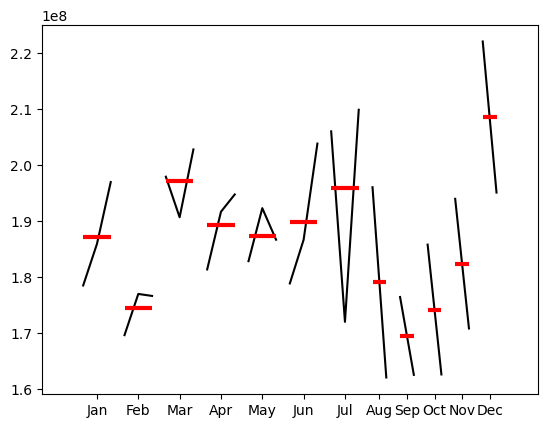

In [16]:
m_plot = month_plot(monthly['Sales'])

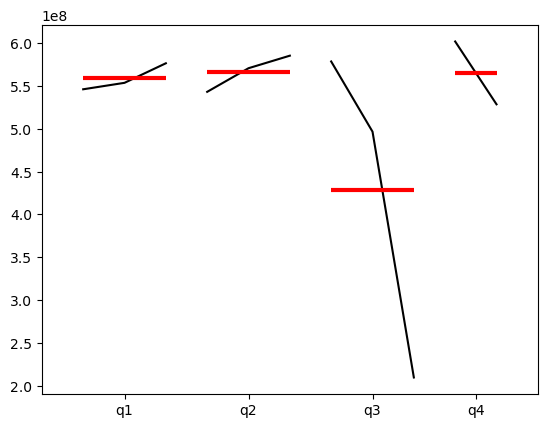

In [17]:
Q_plot = quarter_plot(quarterly['Sales'])

<div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Verdana;text-align:center;
border-radius:15px;
background: linear-gradient(120deg, #F00000, #DC281E, #FFB347); 
text-shadow: 2px 2px 10px #FFD166;
box-shadow: 0px 0px 25px #FFD166;
padding: 10px; height: auto; overflow:hidden; 
backdrop-filter: blur(8px); 
transition: transform 0.3s ease-in-out;"
onmouseover="this.style.transform='scale(1.05)'"
onmouseout="this.style.transform='scale(1)'">
<b> ✨ fit the arima model ✨ </b>
</div>

In [18]:
# fit the arima model
p, d, q = 1, 1, 2
model = ARIMA(df_train['Sales'], order=(p, d, q))
results = model.fit()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-

<div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Verdana;text-align:center;
border-radius:15px;
background: linear-gradient(135deg, #1CD8D2, #93EDC7); 
text-shadow: 2px 2px 10px #C3FFF3;
box-shadow: 0px 0px 25px #93EDC7;
padding: 10px; height: auto; overflow:hidden; 
backdrop-filter: blur(8px); 
transition: transform 0.3s ease-in-out;"
onmouseover="this.style.transform='scale(1.05)'"
onmouseout="this.style.transform='scale(1)'">
<b> ✨ model summary ✨ </b>
</div>

In [19]:
# Display the model summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:              1017209
Model:                 ARIMA(1, 1, 2)   Log Likelihood            -9322550.233
Date:                Wed, 18 Jun 2025   AIC                       18645108.466
Time:                        18:19:20   BIC                       18645155.797
Sample:                             0   HQIC                      18645121.483
                            - 1017209                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6628      0.110     -6.041      0.000      -0.878      -0.448
ma.L1         -0.2828      0.109     -2.589      0.010      -0.497      -0.069
ma.L2         -0.6330      0.104     -6.108      0.0

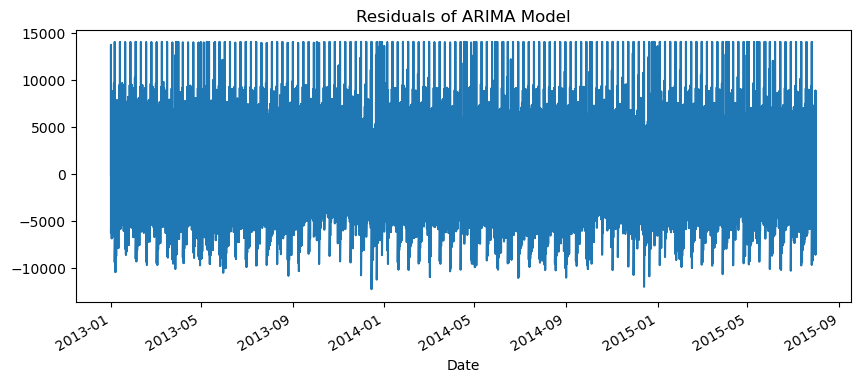

In [20]:
# Plot the residuals of Arima model
residuals = df_train['Sales'] - results.fittedvalues
residuals.plot(figsize = (10,4))
plt.title('Residuals of ARIMA Model')
plt.show()

In [21]:
# Let make the predictions
n_forecast = 6  
forecast = results.forecast(steps = n_forecast)

print('Forecast sales for the next 6 period is: ')
print(forecast)

Forecast sales for the next 6 period is: 
1017209    118.219867
1017210    118.652112
1017211    118.365626
1017212    118.555505
1017213    118.429656
1017214    118.513067
Name: predicted_mean, dtype: float64


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


<div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Verdana;text-align:center;
border-radius:15px;
background: linear-gradient(120deg, #FF4E50, #FC913A, #F9D423); 
text-shadow: 2px 2px 10px #FFD166;
box-shadow: 0px 0px 25px #F9D423;
padding: 10px; height: auto; overflow:hidden; 
backdrop-filter: blur(8px); 
transition: transform 0.3s ease-in-out;"
onmouseover="this.style.transform='scale(1.05)'"
onmouseout="this.style.transform='scale(1)'">
<b> ✨Arima sales for six weeks ahead✨ </b>
</div>

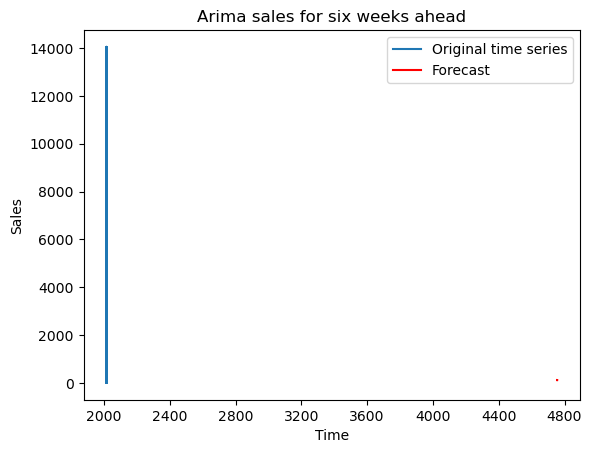

In [22]:
# Plot the original time series and sales values
plt.plot(df_train['Sales'], label = 'Original time series')
plt.plot(np.arange(len(df_train), len(df_train) + n_forecast), forecast, color = 'red', label = 'Forecast')
plt.title('Arima sales for six weeks ahead')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [23]:
# The test set will be the last 6 weeks of the training dataset
n_preds = 7*6

In [24]:
test_valid = df_train.iloc[-n_preds:]
train_valid = df_train.iloc[:-n_preds]

In [25]:
test = train_valid.iloc[-n_preds:]
train = train_valid.iloc[:-n_preds]

In [26]:
mean = df_train['Sales'].mean()
preds_base = test.copy()
preds_base['preds'] = n_preds * [mean]

In [27]:
# Shapes of data
train.shape, test.shape

((1017125, 30), (42, 30))

In [28]:
decomp = seasonal_decompose(x = train['Sales'],model='additive', period = 7, two_sided=False)

<div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Verdana;text-align:center;
border-radius:15px;
background: linear-gradient(135deg, #0F2027, #203A43, #2C5364); 
text-shadow: 2px 2px 10px #89CFF0;
box-shadow: 0px 0px 25px #89CFF0;
padding: 10px; height: auto; overflow:hidden; 
backdrop-filter: blur(8px); 
transition: transform 0.3s ease-in-out;"
onmouseover="this.style.transform='scale(1.05)'"
onmouseout="this.style.transform='scale(1)'">
<b> ✨ Seasonal Component with 6 Weeks Extrapolation ✨ </b>
</div>

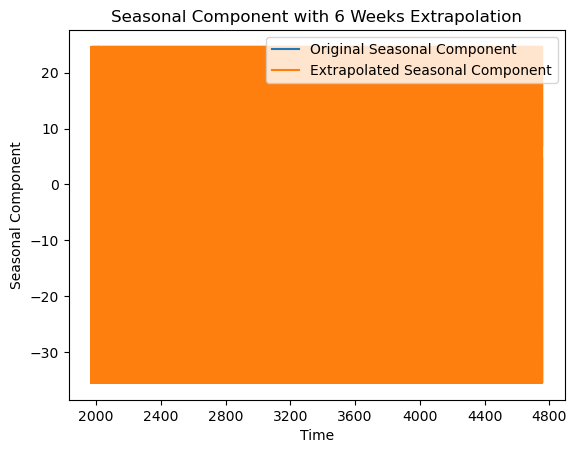

In [29]:
# Extrapolate the seasonal component six weeks ahead
seasonal_component = decomp.seasonal
extrapolated_seasonal_component = pd.concat([seasonal_component, pd.Series([None] * 6)], ignore_index=True)

# Plot the original and extrapolated seasonal component
plt.plot(seasonal_component, label='Original Seasonal Component')
plt.plot(extrapolated_seasonal_component, label='Extrapolated Seasonal Component')
plt.xlabel('Time')
plt.ylabel('Seasonal Component')
plt.title('Seasonal Component with 6 Weeks Extrapolation')
plt.legend()
plt.show()

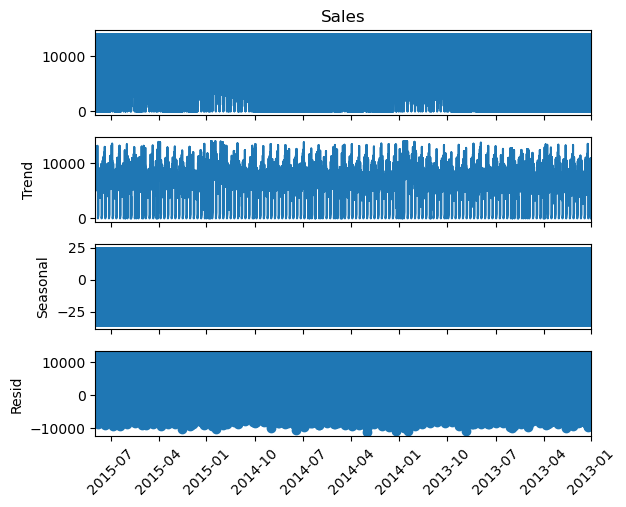

In [30]:
# Plot the data
decomp.plot()
plt.xticks(rotation = 45)
plt.show()

In [31]:
decomp.seasonal

Date
2015-07-31     6.849486
2015-07-31    24.621853
2015-07-31    -7.474809
2015-07-31     4.706091
2015-07-31    -8.188972
                ...    
2013-01-01   -35.533995
2013-01-01     6.849486
2013-01-01    24.621853
2013-01-01    -7.474809
2013-01-01     4.706091
Name: seasonal, Length: 1017125, dtype: float64

In [32]:
trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

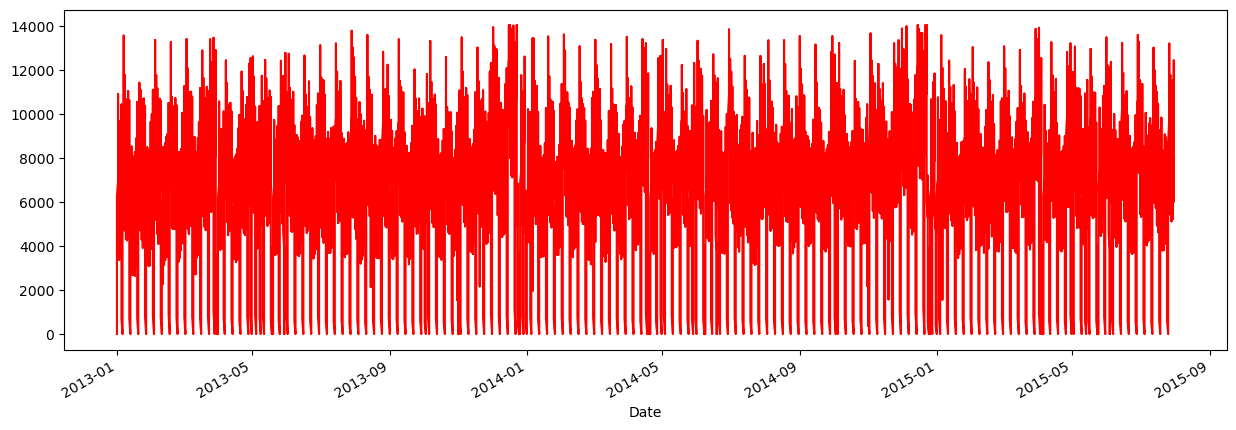

In [33]:
trend.plot(figsize=(15,5), color='red')
plt.show()

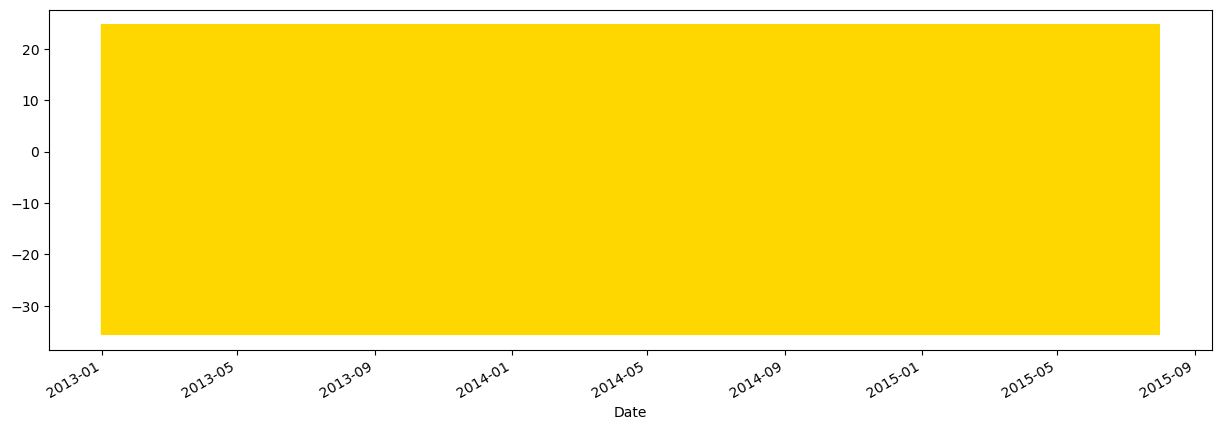

In [34]:
# Plot seasonal
seasonal.plot(figsize=(15,5), color= 'gold')
plt.show()

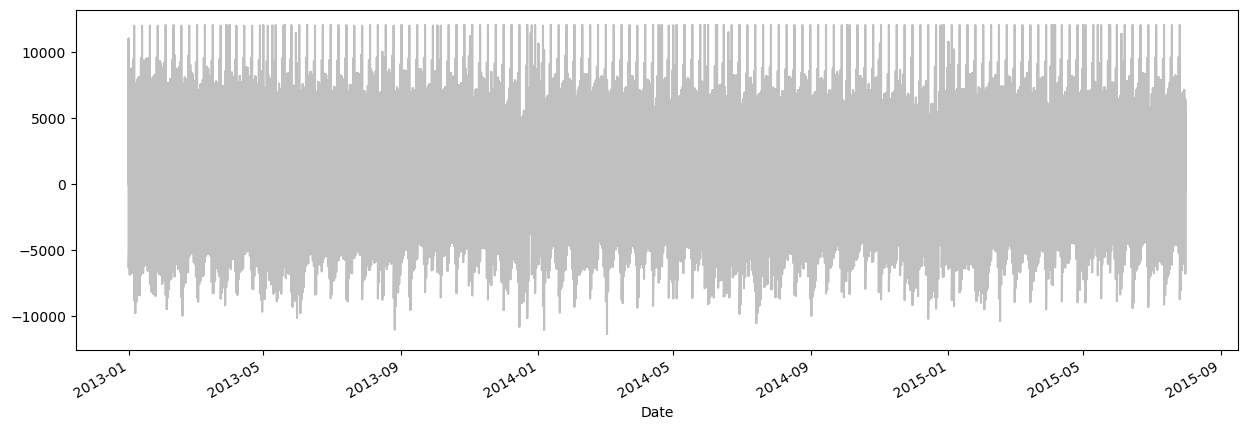

In [35]:
# Plot Residual
residual.plot(figsize = (15,5), color='silver')
plt.show()

In [36]:
ets = ExponentialSmoothing(train['Sales'], trend='add', seasonal='add', seasonal_periods=7).fit()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [37]:
# make prediction
preds = ets.forecast(n_preds)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [38]:
# 6 weeks ahead means 6*7
n_preds

42

In [39]:
preds

1017125    -26.011092
1017126    102.321648
1017127    -25.486193
1017128     40.670208
1017129     -2.879718
1017130    -45.560121
1017131    -47.300864
1017132    -28.261136
1017133    100.071603
1017134    -27.736238
1017135     38.420164
1017136     -5.129763
1017137    -47.810165
1017138    -49.550909
1017139    -30.511181
1017140     97.821558
1017141    -29.986283
1017142     36.170119
1017143     -7.379808
1017144    -50.060210
1017145    -51.800954
1017146    -32.761226
1017147     95.571513
1017148    -32.236327
1017149     33.920074
1017150     -9.629852
1017151    -52.310255
1017152    -54.050998
1017153    -35.011270
1017154     93.321469
1017155    -34.486372
1017156     31.670030
1017157    -11.879897
1017158    -54.560299
1017159    -56.301043
1017160    -37.261315
1017161     91.071424
1017162    -36.736417
1017163     29.419985
1017164    -14.129942
1017165    -56.810344
1017166    -58.551088
dtype: float64

<div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Verdana;text-align:center;
border-radius:15px;
background: linear-gradient(135deg, #0F2027, #203A43, #2C5364); 
text-shadow: 2px 2px 10px #89CFF0;
box-shadow: 0px 0px 25px #89CFF0;
padding: 10px; height: auto; overflow:hidden; 
backdrop-filter: blur(8px); 
transition: transform 0.3s ease-in-out;"
onmouseover="this.style.transform='scale(1.05)'"
onmouseout="this.style.transform='scale(1)'">
<b> ✨ Make time series object ✨ </b>
</div>

In [40]:
# Make time series object
tss = TimeSeriesSplit(n_splits = 2)
df_train.sort_index(inplace=True)
X = df_train.select_dtypes(include=['int64','float64']).drop(labels=['Sales'], axis=1)
y = df_train['Sales']

In [41]:
#Split Train and test data
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [42]:
X_train.index

DatetimeIndex(['2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01',
               ...
               '2014-09-13', '2014-09-13', '2014-09-13', '2014-09-13',
               '2014-09-13', '2014-09-13', '2014-09-13', '2014-09-13',
               '2014-09-13', '2014-09-13'],
              dtype='datetime64[ns]', name='Date', length=678140, freq=None)

In [43]:
X_test.index

DatetimeIndex(['2014-09-13', '2014-09-13', '2014-09-13', '2014-09-13',
               '2014-09-13', '2014-09-13', '2014-09-13', '2014-09-13',
               '2014-09-13', '2014-09-13',
               ...
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31'],
              dtype='datetime64[ns]', name='Date', length=339069, freq=None)

<div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Verdana;text-align:center;
border-radius:15px;
background: linear-gradient(135deg, #DA22FF, #9733EE); 
text-shadow: 2px 2px 10px #E0B3FF;
box-shadow: 0px 0px 25px #C084FC;
padding: 10px; height: auto; overflow:hidden; 
backdrop-filter: blur(8px); 
transition: transform 0.3s ease-in-out;"
onmouseover="this.style.transform='scale(1.05)'"
onmouseout="this.style.transform='scale(1)'">
<b> ✨ Splitting Train and Test data ✨ </b>
</div>

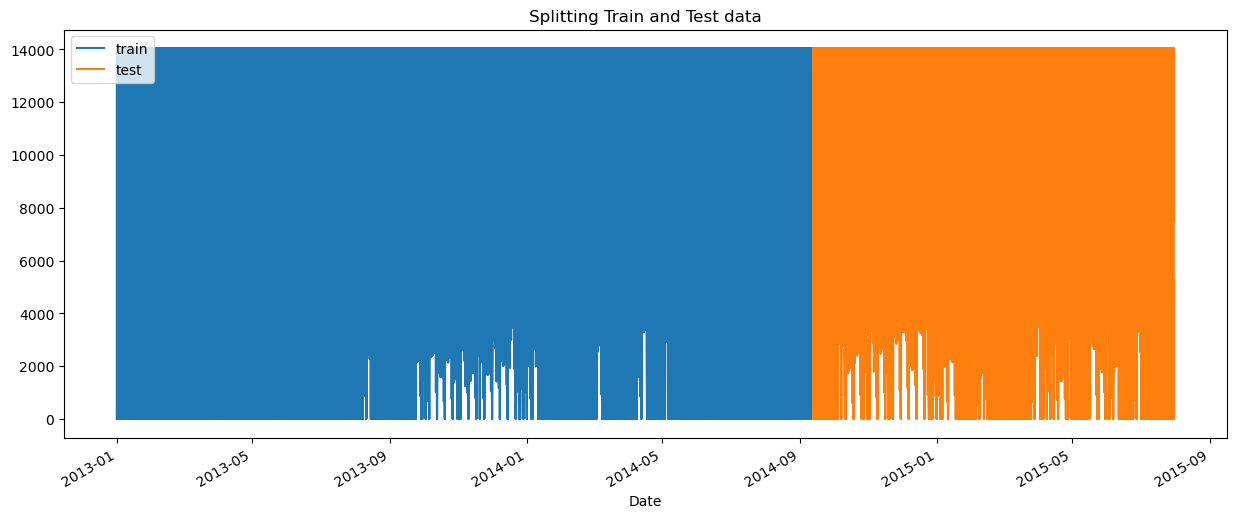

In [44]:
#Visualize the result of splitting
plt.figure(figsize=(15,6))
plt.title('Splitting Train and Test data')
ax = y_train.plot()
y_test.plot(ax=ax)
plt.legend(['train', 'test'])
plt.show()

In [45]:
# #Reshape 1D array to 2D array
y_test = np.array(y_test).reshape(-1,1)
y_train = np.array(y_train).reshape(-1, 1)

In [46]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 678140 entries, 2013-01-01 to 2014-09-13
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      678140 non-null  int64  
 1   DayOfWeek                  678140 non-null  int64  
 2   Customers                  678140 non-null  int64  
 3   Open                       678140 non-null  int64  
 4   Promo                      678140 non-null  int64  
 5   StateHoliday               678140 non-null  float64
 6   SchoolHoliday              678140 non-null  int64  
 7   StoreType                  678140 non-null  float64
 8   Assortment                 678140 non-null  float64
 9   CompetitionDistance        678140 non-null  int64  
 10  CompetitionOpenSinceMonth  678140 non-null  int64  
 11  CompetitionOpenSinceYear   678140 non-null  int64  
 12  Promo2                     678140 non-null  int64  
 13  Promo2SinceWe

In [47]:
# Scale the data
scaler_x = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))
X_train_sc = scaler_x.fit_transform(X_train)
y_train_sc = scaler_y.fit_transform(y_train)
X_test_sc = scaler_x.fit_transform(X_test)
y_test_sc = scaler_y.fit_transform(y_test)

<div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Verdana;text-align:center;
border-radius:15px;
background: linear-gradient(135deg, #DA22FF, #9733EE); 
text-shadow: 2px 2px 10px #E0B3FF;
box-shadow: 0px 0px 25px #C084FC;
padding: 10px; height: auto; overflow:hidden; 
backdrop-filter: blur(8px); 
transition: transform 0.3s ease-in-out;"
onmouseover="this.style.transform='scale(1.05)'"
onmouseout="this.style.transform='scale(1)'">
<b> ✨ Model BUILDING ✨ </b>
</div>

In [48]:
# Build the model simple nn
model = Sequential()
model.add(Dense(12, input_dim=X_train_sc.shape[1], activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [49]:
np.random.seed(455)

In [52]:
early_stop = EarlyStopping(monitor = 'loss', patience = 2, verbose = 1)
history = model.fit(X_train_sc, y_train_sc, epochs=2, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/2
678140/678140 ━━━━━━━━━━━━━━━━━━━━ 1803s 3ms/step - loss: 0.0188
Epoch 2/2
678140/678140 ━━━━━━━━━━━━━━━━━━━━ 1739s 3ms/step - loss: 0.0173


In [53]:
# Define the percentage of data to include in the subset
subset_percentage = 0.01

num_samples = int(subset_percentage * len(X_train_sc))

num_samples_test = 41088

X_train_subset = X_train_sc[:num_samples, :]
y_train_subset = y_train_sc[:num_samples]

X_test_subset = X_test_sc[:num_samples_test, :]
y_test_subset = y_test_sc[:num_samples_test]

In [54]:
# the range should be 41088
len(X_test_subset)

41088

In [55]:
history = model.fit(X_train_subset, y_train_subset, epochs=10, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/10
6781/6781 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0106
Epoch 2/10
6781/6781 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0103
Epoch 3/10
6781/6781 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0102
Epoch 4/10
6781/6781 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0100
Epoch 5/10
6781/6781 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0099
Epoch 6/10
6781/6781 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0098
Epoch 7/10
6781/6781 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0097
Epoch 8/10
6781/6781 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0097
Epoch 9/10
6781/6781 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0097
Epoch 10/10
6781/6781 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0096


In [56]:
#We predict our model and get R2 scores for train and test.
y_pred_test_nn = model.predict(X_test_subset)
y_train_pred_nn = model.predict(X_train_subset)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train_subset, y_train_pred_nn)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test_subset, y_pred_test_nn)))

1284/1284 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
The R2 score on the Train set is:	0.923
The R2 score on the Test set is:	0.846


In [57]:
#Rescale for lSTM 
num_features = X_train_subset.shape[1]
num_samples = len(X_train_subset) - (len(X_train_subset) % num_features)

num_features_test = X_test_subset.shape[1]
num_samples_test = len(X_test_subset) - (len(X_test_subset) % num_features_test)

X_test_subset_lstm = X_test_subset[:num_samples, :]
y_test_subset_lstm = y_test_subset[:num_samples]

X_train_subset_lstm = X_train_subset[:num_samples, :]
y_train_subset_lstm = y_train_subset[:num_samples]

X_train_subset_lstm = X_train_subset_lstm.reshape((-1, num_features, 1))
X_test_subset_lstm = X_test_subset_lstm.reshape((-1, num_features_test, 1))

In [58]:
num_samples_y = X_train_subset_lstm.shape[0]
y_train_subset_lstm = y_train_subset_lstm[:num_samples_y]

<div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Verdana;text-align:center;
border-radius:15px;
background: linear-gradient(135deg, #DA22FF, #9733EE); 
text-shadow: 2px 2px 10px #E0B3FF;
box-shadow: 0px 0px 25px #C084FC;
padding: 10px; height: auto; overflow:hidden; 
backdrop-filter: blur(8px); 
transition: transform 0.3s ease-in-out;"
onmouseover="this.style.transform='scale(1.05)'"
onmouseout="this.style.transform='scale(1)'">
<b> ✨ Build the LSTM model ✨ </b>
</div>

In [59]:
# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(num_features, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

np.random.seed(455)

history = lstm_model.fit(X_train_subset_lstm, y_train_subset_lstm, epochs=10, batch_size=1, verbose=1, shuffle=False)

Epoch 1/10
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 0.0637
Epoch 2/10
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 0.0696
Epoch 3/10
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - loss: 0.0526
Epoch 4/10
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 0.0262
Epoch 5/10
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - loss: 0.0424
Epoch 6/10
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 0.0279
Epoch 7/10
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 0.0317
Epoch 8/10
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - loss: 0.0193
Epoch 9/10
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - loss: 0.0167
Epoch 10/10
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 0.0160


In [60]:
y_pred_test_lstm = lstm_model.predict(X_test_subset_lstm)
y_pred_train_lstm = lstm_model.predict(X_train_subset_lstm)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train_subset_lstm, y_pred_train_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test_subset_lstm, y_pred_test_lstm)))

212/212 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
The R2 score on the Train set is:	0.794
The R2 score on the Test set is:	0.489


In [61]:
#Compare test MSE of both models.
nn_test = model.evaluate(X_test_subset, y_test_subset, batch_size=1)
lstm_test = lstm_model.evaluate(X_test_subset_lstm, y_test_subset_lstm, batch_size=1)
print('NN: %f'%nn_test)
print('LSTM: %f'%lstm_test)

41088/41088 ━━━━━━━━━━━━━━━━━━━━ 67s 2ms/step - loss: 0.0363
6776/6776 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 0.0712
NN: 0.038790
LSTM: 0.123105


In [62]:
#Forecasting
X_future_nn = X_test_subset.copy()
for i in range(1, 7):
    X_future_nn = np.vstack([X_future_nn, X_test_subset[-1]])

nn_y_pred_test_extended = model.predict(X_future_nn)

1285/1285 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [63]:
# Use the trained LSTM model to predict sales values
X_future_lstm = X_test_subset_lstm.copy()
for i in range(1, 7):
    X_future_lstm = np.vstack([X_future_lstm, [X_test_subset_lstm[-1]]])  

y_pred_lstm = lstm_model.predict(X_future_lstm)

212/212 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


In [64]:
y_pred_original_scale = scaler_y.inverse_transform(nn_y_pred_test_extended)

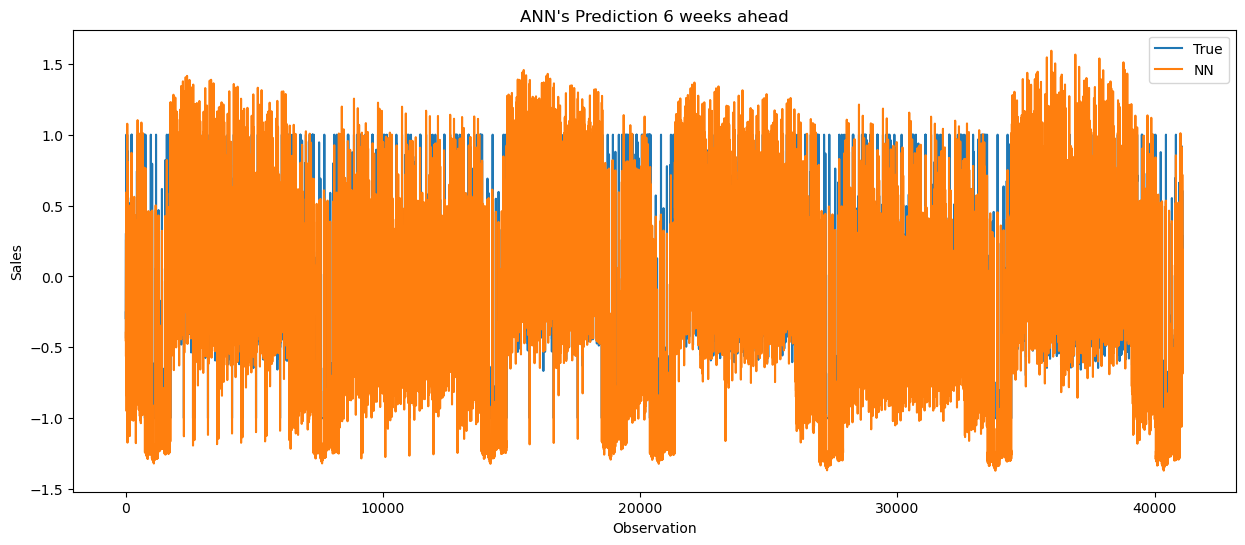

In [65]:
plt.figure(figsize=(15, 6))
plt.plot(y_test_subset, label='True')
plt.plot(nn_y_pred_test_extended, label='NN')
plt.title("ANN's Prediction 6 weeks ahead")
plt.xlabel('Observation')
plt.ylabel('Sales')
plt.legend()
plt.show()

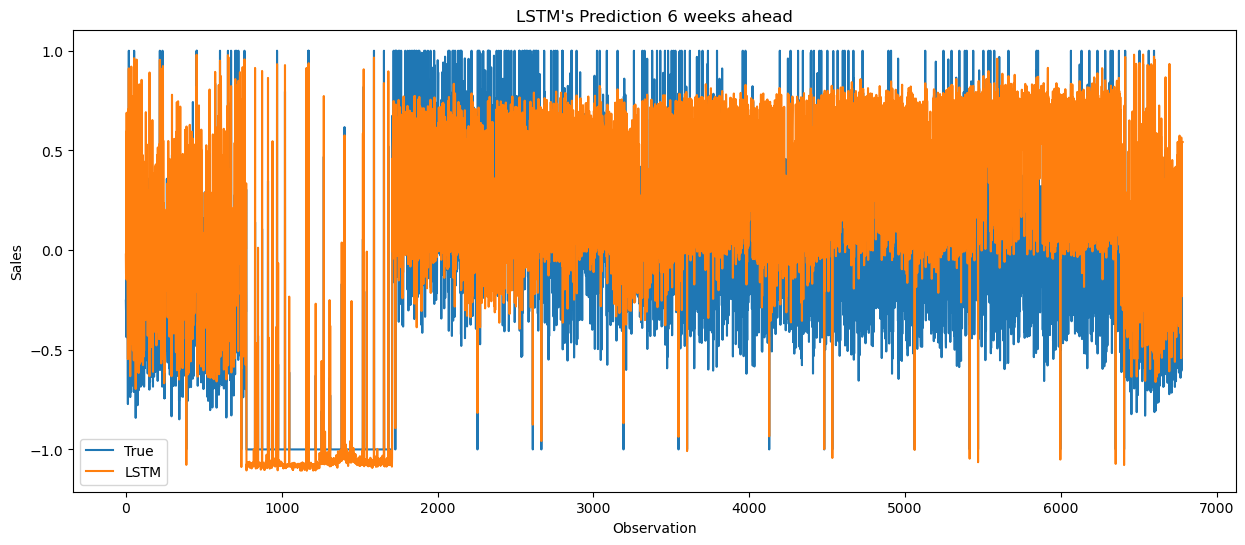

In [66]:
plt.figure(figsize=(15, 6))
plt.plot(y_test_subset_lstm, label='True')
plt.plot(y_pred_lstm, label='LSTM')
plt.title("LSTM's Prediction 6 weeks ahead")
plt.xlabel('Observation')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [67]:
num_elements = len(y_pred_original_scale)
print("Number of elements:", num_elements)
id_column = np.arange(1, num_elements + 1)
print(y_pred_original_scale)

Number of elements: 41094
[[4235.7896]
 [3816.2378]
 [4652.23  ]
 ...
 [7065.7964]
 [7065.7964]
 [7065.7964]]


In [68]:
#project Submission

final_preds= pd.DataFrame({'Id': id_column, 
                          'Sales': y_pred_original_scale.flatten()})
final_preds.to_csv("Sales Forecasting Retail Stores.csv", index = False)

<div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Verdana;text-align:center;
border-radius:15px;
background: linear-gradient(135deg, #DA22FF, #9733EE); 
text-shadow: 2px 2px 10px #E0B3FF;
box-shadow: 0px 0px 25px #C084FC;
padding: 10px; height: auto; overflow:hidden; 
backdrop-filter: blur(8px); 
transition: transform 0.3s ease-in-out;"
onmouseover="this.style.transform='scale(1.05)'"
onmouseout="this.style.transform='scale(1)'">
<b> ✨ Summary of model ✨ </b>
</div>

In [69]:
# Summary of model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12)                  │             348 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              13 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,085 (4.24 KB)

 Trainable params: 361 (1.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 724 (2.83 KB)

In [70]:
model.save('mymodel.h5')

In [71]:
# load model
new_model = load_model('mymodel.h5')
new_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12)                  │             348 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              13 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 363 (1.42 KB)

 Trainable params: 361 (1.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [72]:
print (sys.path)

['C:\\ProgramData\\anaconda3\\python312.zip', 'C:\\ProgramData\\anaconda3\\DLLs', 'C:\\ProgramData\\anaconda3\\Lib', 'C:\\ProgramData\\anaconda3', '', 'C:\\Users\\Dell\\AppData\\Roaming\\Python\\Python312\\site-packages', 'C:\\Users\\Dell\\AppData\\Roaming\\Python\\Python312\\site-packages\\win32', 'C:\\Users\\Dell\\AppData\\Roaming\\Python\\Python312\\site-packages\\win32\\lib', 'C:\\Users\\Dell\\AppData\\Roaming\\Python\\Python312\\site-packages\\Pythonwin', 'C:\\ProgramData\\anaconda3\\Lib\\site-packages', 'C:\\ProgramData\\anaconda3\\Lib\\site-packages\\win32', 'C:\\ProgramData\\anaconda3\\Lib\\site-packages\\win32\\lib', 'C:\\ProgramData\\anaconda3\\Lib\\site-packages\\Pythonwin']


<div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Verdana;text-align:center;
border-radius:15px;
background: linear-gradient(135deg, #DA22FF, #9733EE); 
text-shadow: 2px 2px 10px #E0B3FF;
box-shadow: 0px 0px 25px #C084FC;
padding: 10px; height: auto; overflow:hidden; 
backdrop-filter: blur(8px); 
transition: transform 0.3s ease-in-out;"
onmouseover="this.style.transform='scale(1.05)'"
onmouseout="this.style.transform='scale(1)'">
<b> ✨ Actual vs 6 weeks Predicted Sales in Prophet ✨ </b>
</div>

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:Adding TBB (C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\prophet\stan_model\cmdstan-2.33.1\stan\lib\stan_math\lib\tbb) to PATH
DEBUG:cmdstanpy:input tempfile: C:\Users\Dell\AppData\Local\Temp\tmpwp2y393e\y5z2vwie.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Dell\AppData\Local\Temp\tmpwp2y393e\bxm70ult.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Dell\\AppData\\Roaming\\Python\\Python312\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=65146', 'data', 'file=C:\\Users\\Dell\\AppData\\Local\\Temp\\tmpwp2y393e\\y5z2vwie.json', 'init=C:\\Users\\Dell\\AppData\\Local\\Temp\\tmpwp2y393e\\bxm70ult.json', 'output', 'file=C:\\Users\\Dell\\AppData\\Local\\Temp\\tmpwp2y393e\\prophet_modell66ve6gb\\prophet_model-20250618195634.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:56:34 - cmdstanpy - INFO - Chain [

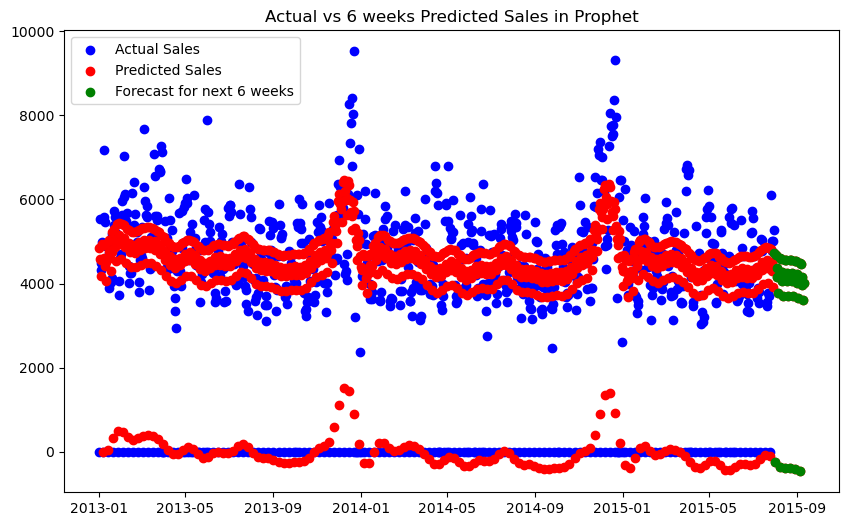

In [73]:
df = pd.read_csv(r"E:\Project_6_Sales Forecasting Across Multiple Retail Store\df_train_for_deeplearning.csv",parse_dates=['Date'])

df = df[df['Store'] == 1] 
df = df[['Date', 'Sales']].rename(columns={'Date':'ds', 'Sales':'y'}) 
df = df.sort_values(by='ds') 

modelpro = Prophet(interval_width=0.95, weekly_seasonality=True, daily_seasonality=True)
modelpro.fit(df)

future = modelpro.make_future_dataframe(periods=6*7, freq='D') 
forecast = modelpro.predict(future)
forecast_next_six_weeks = forecast[['ds', 'yhat']].tail(6*7)
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df['ds'], df['y'], color='blue', label='Actual Sales')
ax.scatter(forecast['ds'], forecast['yhat'], color='red', label='Predicted Sales')
ax.scatter(forecast_next_six_weeks['ds'], forecast_next_six_weeks['yhat'], color='green', label='Forecast for next 6 weeks')
plt.title('Actual vs 6 weeks Predicted Sales in Prophet')
plt.legend()
plt.show()

In [74]:
# load model
new_model = load_model('mymodel.h5')

In [75]:
#Log Parameters, Metrics, and Model to MLFlow
mlflow.set_experiment("sales-forecast-prediction")

<Experiment: artifact_location='file:///C:/Users/Dell/AI%20DIGICROME%20COURSE/mlruns/102679483430756654', creation_time=1750239310714, experiment_id='102679483430756654', last_update_time=1750239310714, lifecycle_stage='active', name='sales-forecast-prediction', tags={}>

In [76]:
with mlflow.start_run(run_name="LSTM Model for Sales forecasting") as run:
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 64)
    mse = new_model.evaluate(X_train_subset, y_train_subset, verbose=1)
    mlflow.log_metric("train_mse", mse)

    mlflow.keras.log_model(new_model, "model")

    model_uri = f"runs:/{run.info.run_id}/model"
    mlflow.register_model(model_uri, "sales forecasting LSTM Model")

    print(f"Model saved and registered with run_id: {run.info.run_id}")

2025/06/18 19:57:23 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0192


2025/06/18 19:57:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/18 19:57:25 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/06/18 19:58:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'sales forecasting LSTM Model'.
2025/06/18 19:58:13 WARNING mlflow.tracking._model_registry.fluent: Run with id a88449d328134cc4a37dda43b002fca5 has no artifacts at artifact path 'model', registering model based on models:/m-83fcf135edea47dc989f7b370cdca151 instead


Model saved and registered with run_id: a88449d328134cc4a37dda43b002fca5


Created version '1' of model 'sales forecasting LSTM Model'.
